In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy.stats as stats
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Abstract

Modeling the effect of AcCh and brain region on lipid levels is better done using normalized, species-level data.  Including a random effect of samples (mixed modeling) seems beneficial.  However, analysis of residuals shows that normal linear models do not fit well in general to the group-level or species-level data.  Linear models with right-skewed error distribution may provide better fit and hence less biased inferences.

## Data sets

The lipid species-level data contains $n_{\mathrm{species} \in \mathrm{group}}$ times more information than the group-level data previously analyzed in the present project.  Therefore, fitting models to species-level data would be advantageous.

| | lipid group-level data | lipid species-level data |
| ------------------------- | ----------- | -------------- |
| a unit of observation | a lipid group in a sample | a lipid species in a sample |
| no. data points per lipid group | $3 \times 10$ samples | $3 \times 10 \times n_{\mathrm{species} \in \mathrm{group}}$ |
| level of $\mathrm{species} \in \mathrm{group}$ assumed i.i.d? (linear model) | yes | yes |


In [2]:
fpath = '../../resources/lipid-data-species-normalized-pretty.csv'
norm_lipid_species = pd.read_csv(fpath, header=[0, 1], index_col=[0, 1])
fpath = '../../resources/lipid-data-species-pretty.csv'
lipid_species = pd.read_csv(fpath, header=[0, 1], index_col=[0, 1])
fpath = '../../resources/demographic-data.csv'
demographic_data = pd.read_csv(fpath, index_col=0)

In [3]:
brain_regions = ['DLPFC', 'CN', 'Putamen']

In [4]:
def to_long_format(wide_data, axis_names=['Group', 'Species', 'Region', 'Subject'], demographic_data=demographic_data):
    s = wide_data.stack(level=1).stack().rename_axis(axis_names)
    endog = s.to_frame('Level')
    exog = s.index.to_frame()
    exog['Dx'] = [re.sub('^(Control|ChAc).*$', '\\1', s) for s in exog.Subject]
    data = pd.concat([endog, exog], axis=1)
    data = data.astype({
        'Region': CategoricalDtype(categories=brain_regions, ordered=True),
        'Dx': CategoricalDtype(categories=['Control', 'ChAc'], ordered=True),
                       })
    demdata = demographic_data.reindex(data.index.get_level_values('Subject'))
    demdata.index = data.index
    data = pd.concat([data, demdata], axis=1)
    return(data)

In [5]:
fpath = '../../resources/lipid-data-groups.csv'
lipid_groups = pd.read_csv(fpath, header=[0, 1], index_col=0)
lipid_groups = lipid_groups.reindex(pd.MultiIndex.from_product([demographic_data.index, brain_regions]), axis=1)
std_lipid_groups = lipid_groups.apply(lambda s: (s - s.mean()) / s.std(), axis=1)
stdgroupdata = to_long_format(std_lipid_groups, ['Group', 'Region', 'Subject'])
stdgroupdata

Level Group   Region    Subject       Dx  \
Group Region  Subject                                                  
FC    CN      ChAc 1    -0.520661    FC       CN     ChAc 1     ChAc   
              ChAc 2    -2.466412    FC       CN     ChAc 2     ChAc   
              ChAc 3     1.146440    FC       CN     ChAc 3     ChAc   
              ChAc 4     1.268065    FC       CN     ChAc 4     ChAc   
              Control 1  1.302206    FC       CN  Control 1  Control   
...                           ...   ...      ...        ...      ...   
NSer  Putamen Control 2  0.443121  NSer  Putamen  Control 2  Control   
              Control 3 -0.351664  NSer  Putamen  Control 3  Control   
              Control 4  0.521406  NSer  Putamen  Control 4  Control   
              Control 5  0.080771  NSer  Putamen  Control 5  Control   
              Control 6 -0.666297  NSer  Putamen  Control 6  Control   

                         AgeAtDeath  
Group Region  Subject                
FC    CN      ChAc 1             51  
              ChAc 2             50  
              ChAc 3             61  
              ChAc 4             40  
              Control 1          53  
...                             ...  
NSer  Putamen Control 2          50  
              Control 3          57  
              Control 4          59  
              Control 5          54  
              Control 6          59  

[1020 rows x 6 columns]

In [6]:
data = to_long_format(lipid_species)
normdata = to_long_format(norm_lipid_species)
data

Level Group     Species   Region  \
Group Species    Region  Subject                                          
FC    FC         CN      ChAc 1     74.76526    FC          FC       CN   
                         ChAc 2     62.75982    FC          FC       CN   
                         ChAc 3     85.05140    FC          FC       CN   
                         ChAc 4     85.80184    FC          FC       CN   
                         Control 1  86.01249    FC          FC       CN   
...                                      ...   ...         ...      ...   
NSer  NSer 22:6  Putamen Control 2   0.00024  NSer  NSer 22:6   Putamen   
                         Control 3   0.00074  NSer  NSer 22:6   Putamen   
                         Control 4   0.00008  NSer  NSer 22:6   Putamen   
                         Control 5   0.00034  NSer  NSer 22:6   Putamen   
                         Control 6   0.00042  NSer  NSer 22:6   Putamen   

                                      Subject       Dx  AgeAtDeath  
Group Species    Region  Subject                                    
FC    FC         CN      ChAc 1        ChAc 1     ChAc          51  
                         ChAc 2        ChAc 2     ChAc          50  
                         ChAc 3        ChAc 3     ChAc          61  
                         ChAc 4        ChAc 4     ChAc          40  
                         Control 1  Control 1  Control          53  
...                                       ...      ...         ...  
NSer  NSer 22:6  Putamen Control 2  Control 2  Control          50  
                         Control 3  Control 3  Control          57  
                         Control 4  Control 4  Control          59  
                         Control 5  Control 5  Control          54  
                         Control 6  Control 6  Control          59  

[17790 rows x 7 columns]

## "Identical distribution" assumption violated

Here I inspect whether unnormalized data might be amenable for fitting regression models.  The heatmaps show that some lipid species within a lipid group have much higher levels across all or most samples than the rest of the species.

In other words: the levels of lipid species in a group are not identically distributed.  This finding has the following implies:

1. In the group-level data some lipid species in a given group have larger weight than other species in that group.  (I assume that each group-level value was obtained by summing the levels of all species in that group.)
1. The species-level data must be normalized across samples to satisfy the identical distribution assumption.

In [7]:
def heatmap(group, is_normalized):
    data = norm_lipid_species if is_normalized else lipid_species
    fig, ax = plt.subplots(1, 3, sharey=True)
    for ix, region in enumerate(brain_regions):
        d = data.xs(group, axis=0, level=0)
        vmin = d.min().min()
        vmax = d.max().max()
        d = d.xs(region, axis=1, level=1)
        ax[ix].imshow(d, interpolation='none', vmin=vmin, vmax=vmax)
        ax[ix].set_title(region)
        ax[ix].set_yticks(range(len(d)))
        ax[ix].set_yticklabels(d.index)
        prefix = 'Normalized' if is_normalized else 'Raw'
        fig.suptitle(prefix + ' ' + group + ' levels', fontsize=14)
    return((fig, ax))

### Lipid group: BMP

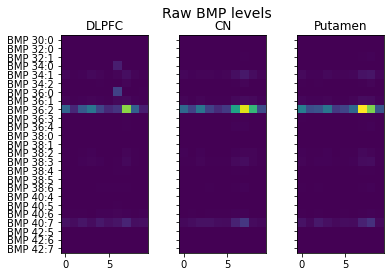

In [8]:
fig, ax = heatmap('BMP', is_normalized=False)

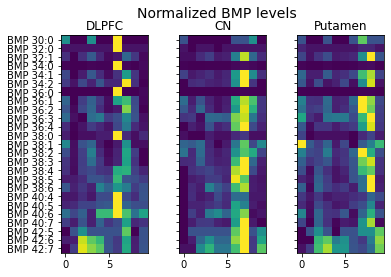

In [9]:
fig, ax = heatmap('BMP', is_normalized=True)

### Lipid group: Sulf

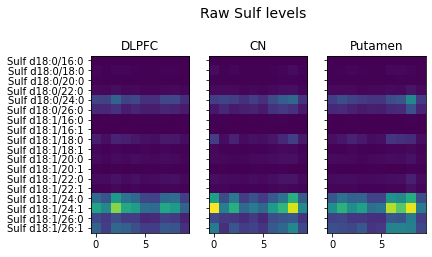

In [10]:
fig, ax = heatmap('Sulf', is_normalized=False)

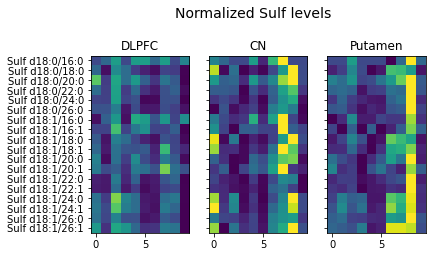

In [11]:
fig, ax = heatmap('Sulf', is_normalized=True)

### Lipid group: PG

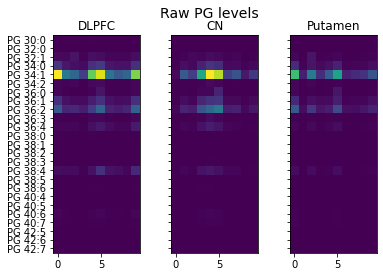

In [12]:
fig, ax = heatmap('PG', is_normalized=False)

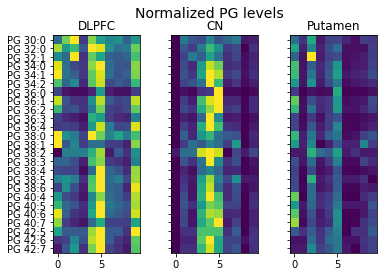

In [13]:
fig, ax = heatmap('PG', is_normalized=True)

## Fitting linear fixed and mixed models

### Group-level data
Let's take the group-level data $Y'_g, X'_g$ for lipid group $g$!  Then the lipid level $y'_{gi}$ of group $g$ and the $i$th sample can be modeled with a fixed effects linear model such as
$$
\begin{equation}
y'_{gi} = \beta'_{0, g} + \beta'_{\mathrm{Dx}, g} x'_{\mathrm{Dx}, i} + \beta'_{\mathrm{Region}, g} x'_{\mathrm{Region}, i} + \beta'_{\mathrm{Dx}:\mathrm{Region}, g} x'_{\mathrm{Dx}, i} x'_{\mathrm{Region}, i} + \epsilon'_{gi}
\end{equation}
$$

Or the data can be modeled with a mixed effects linear model, which has an additional, random effects term $\gamma_i$ relative to the fixed effects terms of the previous model (denoted by $...$)
$$
\begin{equation}
y'_{gi} = ... + \gamma'_{gi} + \epsilon'_{gi},
\end{equation}
$$
where $\gamma_i$ is a random parameter and $\gamma_i = \gamma_j$ if sample $i$ and $j$ both come from the same individual.

### Species-level data
Now let's turn to the (normalized) species-level data $Y_g, X_g$!  The $y_{s\in gi}$ lipid level of species $s\in g$ and the $i$th sample may be modeled as
$$
\begin{equation}
y_{s\in gi} = \beta_{0, g} + \beta_{\mathrm{Dx}, g} x_{\mathrm{Dx}, i} + \beta_{\mathrm{Region}, g} x_{\mathrm{Region}, i} + \beta_{\mathrm{Dx}:\mathrm{Region}, g} x_{\mathrm{Dx}, i} x_{\mathrm{Region}, i} + \epsilon_{s\in gi}
\end{equation}
$$

The mixed effects version similar to the group-level model is:
$$
\begin{equation}
y_{s\in gi} = ... + \gamma_{s\in gi} + \epsilon_{s\in gi},
\end{equation}
$$

### Regression formulas
All four models are expressed with the `Level ~ 1 + Dx + Region + Dx:Region` formula.  The notation and interpretation of possible terms is in the following table

| Term | Interpretation |
|---|---|
| Level | level of lipid, response/endogenous variable |
| 1 | intercept, mean level |
| Region | uniform effect of brain region across all Control and ChAc samples |
| Dx | uniform effect of ChAc level across regions |
| Dx:Region | differential effect of ChAc across regions |
| AgeAtDeath | uniform effect of age at death across all regions and in both Control and ChAc |
| ($\gamma_{s\in gi}$) | random effect of sample and lipid-group |


In [14]:
def extract_group(group, df=data):
    val = df.xs(group, axis=0, level='Group')
    return(val)

def fit_to_group(formula, group, effects='mixed', df=normdata):
    d = extract_group(group, df)
    if effects == 'mixed':
        md = smf.mixedlm(formula, data=d, groups='Subject')
    if effects == 'fixed':
        md = smf.ols(formula, data=d)
    mdf = md.fit()
    return(mdf)

### Models of increasing complexity

More complex models fit the same data in general at least as well, if not better, as (nested) less complex models.  Too complex models, however, tend to overfit the data and the parameter estimates become unstable.

In [15]:
formulas = ['Level ~ 1 + Dx', 'Level ~ 1 + Region', 'Level ~ 1 + Dx:Region', 'Level ~ 1 + Dx:Region + AgeAtDeath', 'Level ~ 1 + Dx + Dx:Region', 'Level ~ 1 + Dx + Region + Dx:Region']
#sel_groups = ['BMP', 'Sulf', 'PG']

In [16]:
def fit_all_models_to_group(group, formulas, normdata=normdata):
    effects = ['fixed', 'mixed']
    l = [[fit_to_group(f, group, fx, df=normdata) for f in formulas] for fx in effects]
    ix = pd.MultiIndex.from_product([effects, formulas])
    res = pd.DataFrame({group: itertools.chain(*l)}, index=ix)
    return(res)

fitted_models = pd.concat([fit_all_models_to_group(group, formulas) for group in lipid_groups.index], axis=1)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.522116
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarn

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimiz

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 5.043945
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarn

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: R

In [17]:
fitted_groupmodels = pd.concat([fit_all_models_to_group(group, formulas, normdata=stdgroupdata) for group in lipid_groups.index], axis=1)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.516307
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: 

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optim

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.250953
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelih

## Inference using various models

The goals of this section: compare inferred effects and their significance across...
1. group-level and species-level data
1. a set of increasingly complex models
1. the presence and absence of random sample effects

### Differential effect of ChAc across regions

Of perhaps the most important biomedical interest is the differential effect of ChAc across regions.  The conclusions from the following analyses are:
1. inference from species-level data is qualitatively consistent with that from group-level data
1. quantitatively viewing it, inference from species-level data yields smaller estimated false negative errors (i.e yields lower $p$-values)
1. the mixed effects flavor gives somewhat greater estimated false negative errors than the fixed effects one

In [18]:
fittedm = {'group-level data': fitted_groupmodels, 'species-level data': fitted_models}

def extract_property(fun, formula='Level ~ 1 + Dx:Region + AgeAtDeath', fittedm=fittedm):
    effects = ['fixed', 'mixed']
    def helper(dataset='group-level data'):
        df = fittedm[dataset].xs(formula, level=1, axis=0)
        res = pd.concat([df.loc[fx].apply(fun) for fx in effects], axis=1)
        res.columns = pd.MultiIndex.from_product([[dataset], effects])
        return(res)
    l = [helper(ds) for ds in fittedm.keys()]
    res = pd.concat(l, axis=1)
    return(res)

fun = lambda m: m.tvalues.loc['Dx[T.ChAc]:Region[CN]']
tvalues = extract_property(fun)
#tvalues

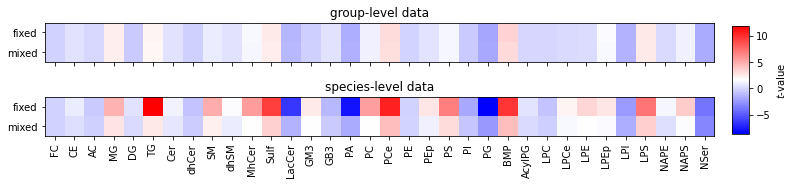

In [19]:
def imshow_extracted(extracted, cb_label, cmap='bwr', autoscale=True, vmin=0, vmax=1):
    fig, ax = plt.subplots(2, 1, figsize=(12, 2.5), sharex=True)
    datasets = extracted.xs('fixed', level=1, axis=1).columns
    vmin = extracted.min(axis=0).min() if autoscale else vmin
    vmax = extracted.max(axis=0).max() if autoscale else vmax
    for axi, dset in zip(ax, datasets):
        df = extracted.xs(dset, level=0, axis=1)
        axi.imshow(df.transpose(), cmap=cmap, vmin=vmin, vmax=vmax)
        axi.set_title(dset)
        axi.set_yticks(range(df.shape[1]))
        axi.set_yticklabels(df.columns)
        axi.set_xticks(range(df.shape[0]))
        axi.set_xticklabels(df.index, rotation=90)
    cm = plt.cm.ScalarMappable(cmap=cmap)
    cm.set_clim(vmin=vmin, vmax=vmax)
    cb_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    fig.colorbar(cm, cax=cb_ax, label=cb_label)
    #fig.suptitle(suptitle, fontsize=14)
    return((fig, ax))

fig, ax = imshow_extracted(tvalues, r'$t$-value')

In [20]:
fun = lambda m: np.log10(m.pvalues.loc['Dx[T.ChAc]:Region[CN]'])
pvalues = extract_property(fun)
pvalues

group-level data           species-level data          
                  fixed     mixed              fixed     mixed
FC            -0.048671 -0.049027          -0.048671 -0.049027
CE            -0.175955 -0.176721          -0.418083 -0.127955
AC            -0.034746 -0.032234          -0.218043 -0.079360
MG            -1.501381 -1.657181          -5.460368 -2.210319
DG            -0.216861 -0.212547          -0.193362 -0.065810
TG            -1.287209 -1.355383         -30.275062 -1.957674
Cer           -0.185721 -0.181233          -0.546401 -0.257969
dhCer         -0.090720 -0.088790          -0.321439 -0.151433
SM            -0.398124 -0.403135          -5.959922 -1.593253
dhSM          -0.194039 -0.195937          -0.884417 -0.421839
MhCer         -0.713230 -0.705567          -7.453937 -1.006986
Sulf          -1.703806 -1.775709         -18.617829 -3.346392
LacCer        -0.657899 -0.639640          -9.698131 -0.852274
GM3           -0.111419 -0.111379          -1.885522 -0.978565
GB3           -0.180312 -0.181086          -0.628343 -0.202966
PA            -0.926912 -0.902648         -14.015428 -1.149976
PC            -0.518934 -0.521737          -7.390447 -1.052711
PCe           -2.198783 -2.481341         -23.457843 -4.596742
PE            -0.042609 -0.043081          -0.065795 -0.024073
PEp           -0.214410 -0.216883          -2.048429 -0.532547
PS            -0.659863 -0.676017         -10.588009 -2.667636
PI            -0.218818 -0.216886          -1.226322 -0.268175
PG            -1.174094 -1.206654         -16.432138 -1.914961
BMP           -2.599015 -2.771600         -20.708052 -4.715702
AcylPG        -0.009826 -0.009189          -0.253139 -0.061444
LPC           -0.002090 -0.002094          -0.316940 -0.136252
LPCe          -0.068208 -0.068530          -1.391660 -0.752253
LPE           -0.093990 -0.093257          -2.884175 -0.977600
LPEp          -0.759838 -0.739483          -2.096654 -0.802369
LPI           -0.792928 -0.814803          -1.796827 -0.994071
LPS           -1.767139 -1.868033         -11.458453 -3.438724
NAPE          -0.066198 -0.062091          -0.682243 -0.138780
NAPS          -0.506393 -0.521638          -3.549804 -0.918909
NSer          -1.050784 -1.078044          -3.968654 -2.944012

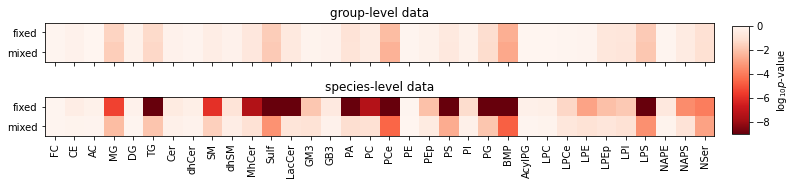

In [21]:
fig, ax = imshow_extracted(pvalues, r'$\log_{10}p$-value', cmap='Reds_r', autoscale=False, vmin=-9, vmax=0)

## Goodness of fit: Jarque-Bera test

Here I perform the [Jarque-Bera goodness of fit test](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test), which assesses whether the normality assumption of linear modeling holds.  The test results show that
1. the assumption is violated for many data sets and models
1. adding the random effects of individuals improves fit
1. the adding the Dx:Region interaction term substantially improves the fit
1. normality is rejected less confidently (at a greater $p$-value) in the group-level data than in the species-level data

The last point is not surprising when we recall that the group-level data contains fewer points than the species-level data.


In [22]:
#fitted_models.applymap(lambda m: sms.jarque_bera(m.resid)[1])

In [23]:
#fitted_groupmodels.applymap(lambda m: sms.jarque_bera(m.resid)[1])

In [24]:
def imshow_model_property(ax, fun, effects='fixed', vmin=-6, vmax=0,
                          cmap='RdYlGn', fitted_models=fitted_models,
                          cb_label=r'$- \log_{10}p$-value', suptitle='Goodness of fit:  Jarque-Bera test'):
    data = fitted_models.xs(effects, level=0, axis=0)
    image = data.applymap(fun)
    ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title('Linear ' + effects + ' effects models')
    ax.set_xticks(range(data.shape[1]))
    ax.set_xticklabels(data.columns, rotation=90)
    ax.set_yticks(range(data.shape[0]))
    ax.set_yticklabels(data.index)
    cm = plt.cm.ScalarMappable(cmap=cmap)
    cm.set_clim(vmin=vmin, vmax=vmax)
    cb_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    fig.colorbar(cm, cax=cb_ax, label=cb_label)
    fig.suptitle(suptitle, fontsize=14)
    return(ax)

<ipython-input-25-ef07b78e9578>:2: RuntimeWarning: divide by zero encountered in log10
  fun = lambda m: np.log10(sms.jarque_bera(m.resid)[1])


<AxesSubplot:title={'center':'Linear mixed effects models'}>

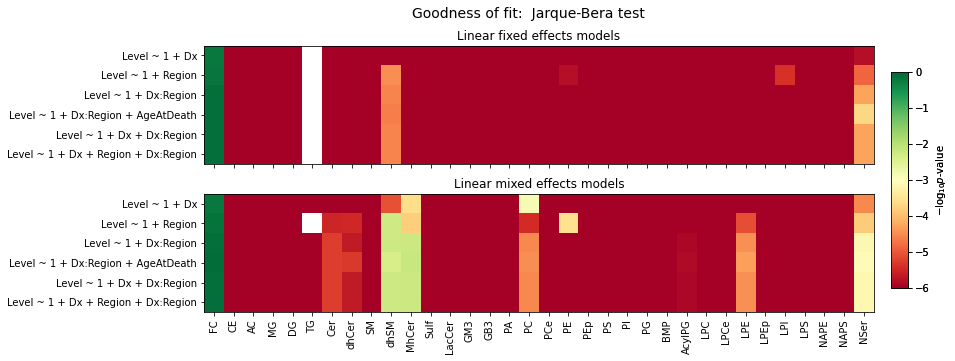

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
fun = lambda m: np.log10(sms.jarque_bera(m.resid)[1])
imshow_model_property(ax[0], fun, 'fixed')
imshow_model_property(ax[1], fun, 'mixed')

<AxesSubplot:title={'center':'Linear mixed effects models'}>

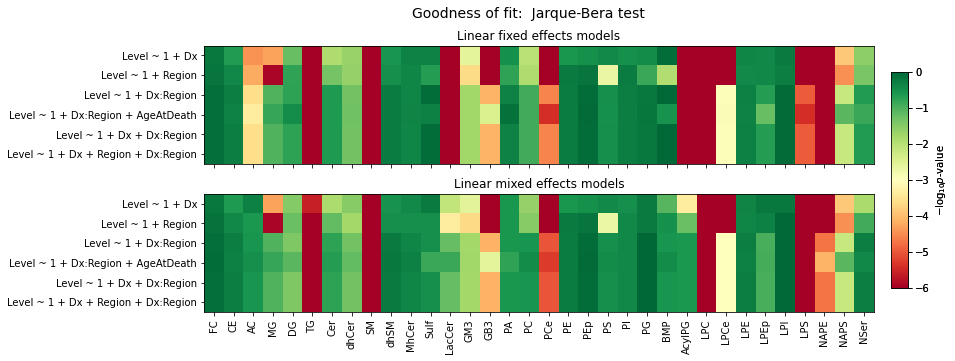

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
fun = lambda m: np.log10(sms.jarque_bera(m.resid)[1])
imshow_model_property(ax[0], fun, 'fixed', fitted_models=fitted_groupmodels)
imshow_model_property(ax[1], fun, 'mixed', fitted_models=fitted_groupmodels)

## Goodness of fit: normal QQ plot of Pearson residuals

Inspecting the distribution of Pearson residuals we see, again, that in most cases they tend to be distributed non-normally for most lipid groups and models.  Further points:
1. the distribution of residuals is right-skewed (whereas the assumption is the unskewed, normal distribution)
1. for a given regression formula the group-level and species level data show similar departure from normality

In [27]:
def qqplot_group(group, effects='fixed'):
    data = fitted_models[group].xs(effects, axis=0, level=0)
    gdata = fitted_groupmodels[group].xs(effects, axis=0, level=0)
    formulas = data.index[[0, 3, 4]]
    fig, ax = plt.subplots(1, len(formulas), figsize=(15, 5), sharey=True)
    for formula, axi in zip(formulas, ax):
        m = data.loc[formula]
        gm = gdata.loc[formula]
        #sm.qqplot(m.resid, stats.norm, marker='.', ax=axi, line='45')
        sm.qqplot(gm.resid_pearson, stats.norm, marker='o', color='C0', ax=axi, linestyle='solid', linewidth=2)
        sm.qqplot(m.resid_pearson, stats.norm, marker='.', color='C2', ax=axi, linestyle='solid', line='45', linewidth=1)
        axi.set_aspect(1)
        axi.set_title(formula, rotation=0, fontsize=10)
    fig.suptitle('Goodness of fit onto the ' + group + ' data', fontsize=14)
    gline = Line2D([0, 1], [0, 0], linewidth=2, color='C0', label='group-level data', marker='o')
    line = Line2D([0, 1], [1, 1], linewidth=1, color='C2', label='species-level data', marker='.')
    fig.legend(handles=[gline, line])
    return((fig, ax))

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


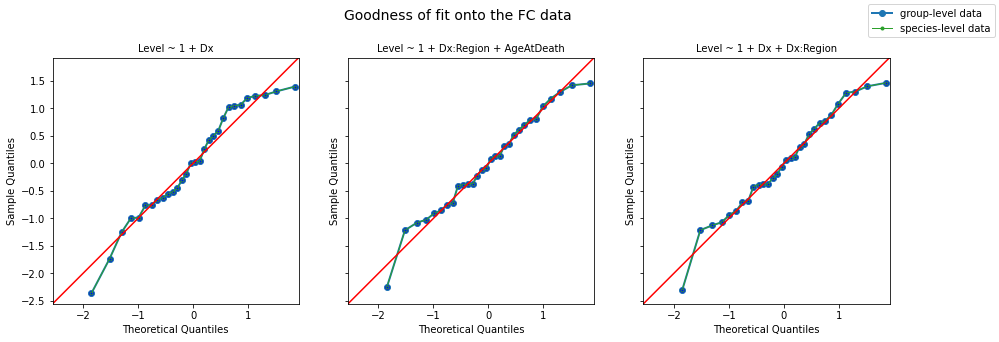

In [28]:
fig, ax = qqplot_group('FC')

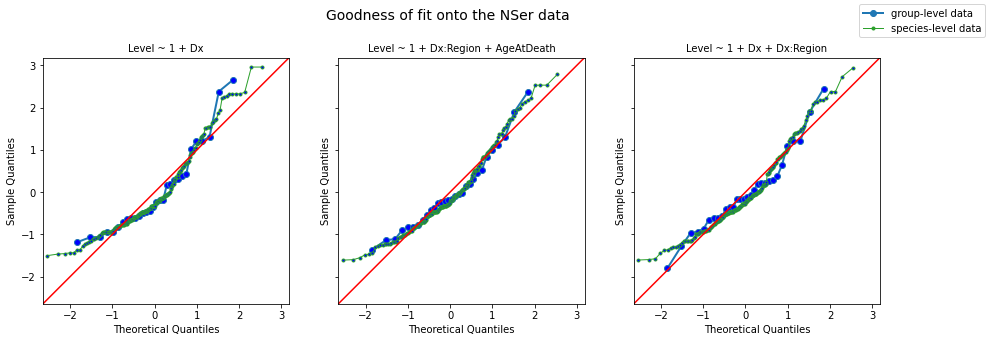

In [29]:
fig, ax = qqplot_group('NSer')

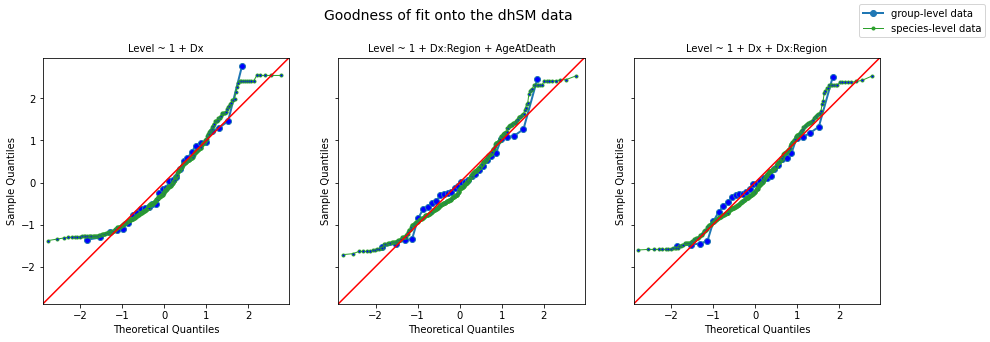

In [30]:
fig, ax = qqplot_group('dhSM')

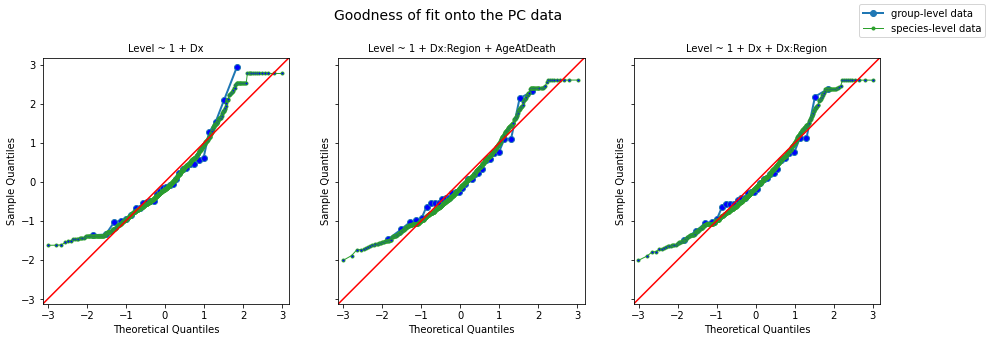

In [31]:
fig, ax = qqplot_group('PC')

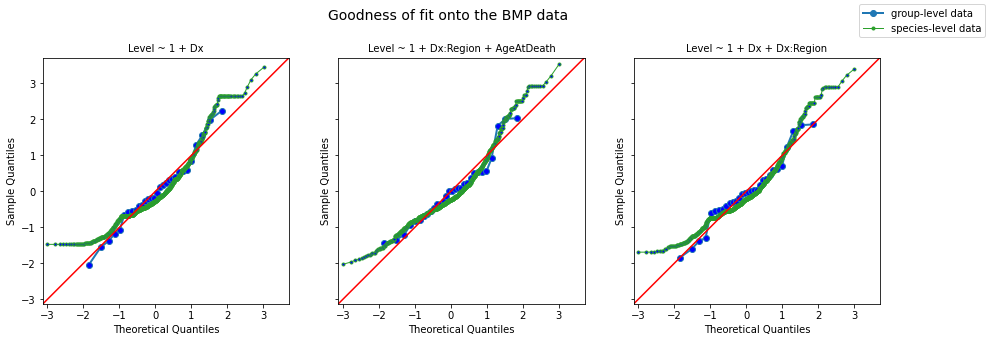

In [32]:
fig, ax = qqplot_group('BMP')

In [33]:
%connect_info

{
  "shell_port": 50482,
  "iopub_port": 50483,
  "stdin_port": 50484,
  "control_port": 50486,
  "hb_port": 50485,
  "ip": "127.0.0.1",
  "key": "73f86017-1308ee30fb20e42b70b5a750",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-5b5c1f05-f93a-4dd1-82cf-4283a8a74864.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
